# **FIAP - Datathon - Fase 5**
* Curso: Especialização em Data Analytics
* Aluno: Rubens Ribeiro Campos
* RM: 35870
* [Link do repositório do GitHub](https://github.com/rcrubens/fiap_datathon)
* [Link da aplicação no Streamlit](https://fiap-datathon-rubens.streamlit.app/)
* [Link do vídeo com a apresentação no formato gerencial](https://www.youtube.com/watch?v=U0j_uXz-FY8)

## **Inteligência Artificial Aplicada à Seleção de Talentos — Projeto Decision**
### 1. **Contexto e Desafio da Empresa**
> A Decision é uma empresa especializada em recrutamento, atuando com modelo bodyshop. Seu desafio central é encontrar os candidatos ideais com agilidade e qualidade, minimizando riscos de seleção inadequada.

> **Dores identificadas no processo atual:**
- Entrevistas não padronizadas: perda de insights relevantes.
- Dificuldade de identificar o real engajamento do candidato.
- Processo manual e pouco eficiente para cruzar perfil com vaga.
### 2. **Objetivo do Projeto**
> Desenvolver um MVP de Inteligência Artificial que melhore o processo de recrutamento e ofereça suporte à tomada de decisão, usando dados históricos para prever a probabilidade de contratação.

### 3. **Preparação do ambiente**

#### 3.1. Importação das bibliotecas

In [9]:
import zipfile
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import joblib
import random

#### 3.2. Verificação das versões instaladas
> Essa verificação facilita a confecção do arquivo requirements.txt que será utilizado no deploy da aplicação no Streamlit

In [10]:
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)

pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
scikit-learn: 1.6.1
joblib: 1.5.1


#### 3.3. Definição de funções

In [11]:
# Converte um JSON compactado em .zip para um DataFrame plano e analisável

def ler_json(caminho_zip):

    with zipfile.ZipFile(caminho_zip) as zip_ref:
        with zip_ref.open(zip_ref.namelist()[0]) as file:
            dados = json.load(file)

    linhas = []

    for chave_id, conteudo in dados.items():
        linha_base = {'ID': chave_id}

        for secao, valores in conteudo.items():
            if isinstance(valores, dict):
                for subchave, subvalor in valores.items():
                    linha_base[f"{secao}.{subchave}"] = subvalor

            elif isinstance(valores, list):
                for item in valores:
                    if isinstance(item, dict):
                        linha_lista = linha_base.copy()
                        for k, v in item.items():
                            linha_lista[f"{secao}.{k}"] = v
                        linhas.append(linha_lista)
                    else:
                        linha_lista = linha_base.copy()
                        linha_lista[secao] = item
                        linhas.append(linha_lista)

            else:
                linha_base[secao] = valores

        if all(not isinstance(v, list) for v in conteudo.values()):
            linhas.append(linha_base)

    return pd.DataFrame(linhas)


In [12]:
# Seleciona colunas com muitos nulos ou variedade excessiva para remoção

def colunas_a_eliminar(df, limite_nulos=90.0, limite_cardinalidade=50):

    total_linhas = len(df)

    perc_nulos = df.isnull().sum() / total_linhas * 100
    colunas_muitos_nulos = perc_nulos[perc_nulos > limite_nulos].index.tolist()

    colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns
    colunas_alta_cardinalidade = [col for col in colunas_categoricas if df[col].nunique() > limite_cardinalidade]

    colunas_candidatas = set(colunas_muitos_nulos + colunas_alta_cardinalidade)

    colunas_a_excluir = [col for col in colunas_candidatas if not col.lower().startswith('codigo')]

    return colunas_a_excluir

In [13]:
# Lista os valores únicos (não nulos) de cada coluna do DataFrame

def extrair_valores_possiveis(df: pd.DataFrame) -> dict:

    valores_possiveis = {
        col: df[col].dropna().unique().tolist()
        for col in df.columns
    }

    return valores_possiveis

In [14]:
# Calcula e exibe graficamente o quanto um candidato se alinha ao perfil ideal previsto pelo modelo

def radar_por_aderencia_modelo(linha, modelo, valores_possiveis, titulo='Radar do Candidato'):

    radar_scores = {}

    for coluna, opcoes in valores_possiveis.items():
        if coluna not in linha:
            continue

        resultados = []
        for val in opcoes:
            linha_temp = linha.copy()
            linha_temp[coluna] = val
            prob = modelo.predict_proba(pd.DataFrame([linha_temp]))[0][1]
            resultados.append((val, prob))

        # Probabilidade real do candidato com o valor atual
        valor_real = linha[coluna]
        prob_real = next((p for v, p in resultados if v == valor_real), None)
        max_prob = max(p for _, p in resultados)

        # Score normalizado de 0 a 10 baseado na aderência
        score = 10 * prob_real / max_prob if (max_prob and prob_real is not None) else 0
        radar_scores[coluna.replace('_', ' ').title()] = score

    labels = list(radar_scores.keys())
    values = list(radar_scores.values())
    values += values[:1]
    angles = [n / float(len(labels)) * 2 * np.pi for n in range(len(labels))]
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], labels, color='grey', size=10)
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, 'skyblue', alpha=0.4)
    chance = modelo.predict_proba(pd.DataFrame([linha]))[0][1]
    plt.title(f"{titulo}\nChance de contratação: {chance:.2%}", size=14, color='navy', y=1.1)
    plt.show()

    return radar_scores

### 4. **Base de Dados e Estratégia**
**Fontes de dados utilizadas:**
- Aplicants.zip: perfil dos candidatos.
- Prospects.zip: histórico de candidatura e status.
- Vagas.zip: características das vagas ofertadas.

> Utilizamos técnicas de engenharia de dados para unificar essas bases e limpar inconsistências com foco em centralizar o perfil do candidato e sua aderência ao conjunto das vagas e não vaga por vaga.

In [15]:
applicants = ler_json('applicants.zip')
applicants.head()

,ID,infos_basicas.telefone_recado,infos_basicas.telefone,infos_basicas.objetivo_profissional,infos_basicas.data_criacao,infos_basicas.inserido_por,infos_basicas.email,infos_basicas.local,infos_basicas.sabendo_de_nos_por,infos_basicas.data_atualizacao,...,cargo_atual.id_ibrati,cargo_atual.email_corporativo,cargo_atual.cargo_atual,cargo_atual.projeto_atual,cargo_atual.cliente,cargo_atual.unidade,cargo_atual.data_admissao,cargo_atual.data_ultima_promocao,cargo_atual.nome_superior_imediato,cargo_atual.email_superior_imediato
0,31000,,(11) 97048-2708,,10-11-2021 07:29:49,Luna Correia,carolina_aparecida@gmail.com,,,10-11-2021 07:29:49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31001,,(11) 93723-4396,Analista Administrativo,10-11-2021 08:56:16,Laura Pacheco,eduardo_rios@hotmail.com,"São Paulo, São Paulo",Outros,11-11-2021 11:10:31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31002,,(11) 92399-9824,Administrativo | Financeiro,10-11-2021 09:01:00,Laura Pacheco,pedro_henrique_carvalho@gmail.com,"São Paulo, São Paulo",Anúncio,10-11-2021 11:42:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31003,,(11) 98100-1727,Área administrativa,10-11-2021 09:08:13,Laura Pacheco,thiago_barbosa@hotmail.com,"São Paulo, São Paulo",Site de Empregos,10-11-2021 16:04:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31004,,(11) 92517-2678,,10-11-2021 09:18:46,Maria Clara Pires,diogo_das_neves@hotmail.com,,,10-11-2021 09:22:03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
applicants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42482 entries, 0 to 42481
Data columns (total 58 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   ID                                                42482 non-null  object
 1   infos_basicas.telefone_recado                     42482 non-null  object
 2   infos_basicas.telefone                            42482 non-null  object
 3   infos_basicas.objetivo_profissional               42482 non-null  object
 4   infos_basicas.data_criacao                        42482 non-null  object
 5   infos_basicas.inserido_por                        42482 non-null  object
 6   infos_basicas.email                               42482 non-null  object
 7   infos_basicas.local                               42482 non-null  object
 8   infos_basicas.sabendo_de_nos_por                  42482 non-null  object
 9   infos_basicas.data_atualizac

In [17]:
prospects = ler_json('prospects.zip')
prospects.head()

,ID,titulo,modalidade,prospects.nome,prospects.codigo,prospects.situacao_candidado,prospects.data_candidatura,prospects.ultima_atualizacao,prospects.comentario,prospects.recrutador
0,4530,CONSULTOR CONTROL M,,José Vieira,25632,Encaminhado ao Requisitante,25-03-2021,25-03-2021,"Encaminhado para - PJ R$ 72,00/hora",Ana Lívia Moreira
1,4530,CONSULTOR CONTROL M,,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,22-03-2021,23-03-2021,"encaminhado para - R$ 6.000,00 – CLT Full , n...",Ana Lívia Moreira
2,4531,2021-2607395-PeopleSoft Application Engine-Dom...,,Sra. Yasmin Fernandes,25364,Contratado pela Decision,17-03-2021,12-04-2021,Data de Inicio: 12/04/2021,Juliana Cassiano
3,4531,2021-2607395-PeopleSoft Application Engine-Dom...,,Alexia Barbosa,25360,Encaminhado ao Requisitante,17-03-2021,17-03-2021,,Juliana Cassiano
4,4533,2021-2605708-Microfocus Application Life Cycle...,,Arthur Almeida,26338,Contratado pela Decision,29-04-2021,18-05-2021,,Stella Vieira


In [18]:
prospects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53759 entries, 0 to 53758
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID                            53759 non-null  object
 1   titulo                        53759 non-null  object
 2   modalidade                    53759 non-null  object
 3   prospects.nome                53759 non-null  object
 4   prospects.codigo              53759 non-null  object
 5   prospects.situacao_candidado  53759 non-null  object
 6   prospects.data_candidatura    53759 non-null  object
 7   prospects.ultima_atualizacao  53759 non-null  object
 8   prospects.comentario          53759 non-null  object
 9   prospects.recrutador          53759 non-null  object
dtypes: object(10)
memory usage: 4.1+ MB


In [19]:
prospects = prospects.rename(columns={'ID': 'codigo_vaga', 'prospects.codigo': 'codigo_candidato'})

In [20]:
vagas = ler_json('vagas.zip')
vagas.head()

,ID,informacoes_basicas.data_requicisao,informacoes_basicas.limite_esperado_para_contratacao,informacoes_basicas.titulo_vaga,informacoes_basicas.vaga_sap,informacoes_basicas.cliente,informacoes_basicas.solicitante_cliente,informacoes_basicas.empresa_divisao,informacoes_basicas.requisitante,informacoes_basicas.analista_responsavel,...,perfil_vaga.demais_observacoes,perfil_vaga.viagens_requeridas,perfil_vaga.equipamentos_necessarios,beneficios.valor_venda,beneficios.valor_compra_1,beneficios.valor_compra_2,informacoes_basicas.data_inicial,informacoes_basicas.data_final,perfil_vaga.habilidades_comportamentais_necessarias,informacoes_basicas.nome_substituto
0,5185,04-05-2021,00-00-0000,Operation Lead -,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Srta. Bella Ferreira,...,100% Remoto Período – entre 5 – 6 meses,,Nenhum -,-,R$,,NaN,NaN,NaN,NaN
1,5184,04-05-2021,00-00-0000,Consultor PP/QM Sênior,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Yasmin da Rosa,...,• Início: Imediato • Fim: Jan/22,,Nenhum -,-,R$,,NaN,NaN,NaN,NaN
2,5183,04-05-2021,00-00-0000,ANALISTA PL/JR C/ SQL,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Ana Albuquerque,...,Localização: Remoto Perfil: Analista Pleno ou ...,,Nenhum -,-,R$,,NaN,NaN,NaN,NaN
3,5182,04-05-2021,18-05-2021,Technical Architect - 11894809,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Clara Rios,...,Budgeted Rate - indicate currency and type (ho...,Não,Notebook padrão -,- p/ mês (168h),fechado,,18-05-2021,17-01-2022,NaN,NaN
4,5181,04-05-2021,00-00-0000,Consultor SAP AUTHORIZATION (BCA) -Pleno / Sênior,Não,Mann and Sons,Cauê Fogaça,Decision São Paulo,Maria Laura Nogueira,Srta. Bella Ferreira,...,contratação CLT full pela Decision locação rem...,Sim,Nenhum -,-,R$,,NaN,NaN,NaN,NaN


In [21]:
vagas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14081 entries, 0 to 14080
Data columns (total 45 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   ID                                                    14081 non-null  object
 1   informacoes_basicas.data_requicisao                   14081 non-null  object
 2   informacoes_basicas.limite_esperado_para_contratacao  14081 non-null  object
 3   informacoes_basicas.titulo_vaga                       14081 non-null  object
 4   informacoes_basicas.vaga_sap                          14081 non-null  object
 5   informacoes_basicas.cliente                           14081 non-null  object
 6   informacoes_basicas.solicitante_cliente               14081 non-null  object
 7   informacoes_basicas.empresa_divisao                   14081 non-null  object
 8   informacoes_basicas.requisitante                      14081 non-nu

In [22]:
# vagas.set_index('ID', inplace=True)

# merged = prospects.merge(vagas, left_on='codigo_vaga', right_index=True)
# merged.head()

In [23]:
applicants.set_index('ID', inplace=True)

merged = prospects.merge(applicants, left_on='codigo_candidato', right_index=True)
merged.head()

,codigo_vaga,titulo,modalidade,prospects.nome,codigo_candidato,prospects.situacao_candidado,prospects.data_candidatura,prospects.ultima_atualizacao,prospects.comentario,prospects.recrutador,...,cargo_atual.id_ibrati,cargo_atual.email_corporativo,cargo_atual.cargo_atual,cargo_atual.projeto_atual,cargo_atual.cliente,cargo_atual.unidade,cargo_atual.data_admissao,cargo_atual.data_ultima_promocao,cargo_atual.nome_superior_imediato,cargo_atual.email_superior_imediato
0,4530,CONSULTOR CONTROL M,,José Vieira,25632,Encaminhado ao Requisitante,25-03-2021,25-03-2021,"Encaminhado para - PJ R$ 72,00/hora",Ana Lívia Moreira,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,CONSULTOR CONTROL M,,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,22-03-2021,23-03-2021,"encaminhado para - R$ 6.000,00 – CLT Full , n...",Ana Lívia Moreira,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4531,2021-2607395-PeopleSoft Application Engine-Dom...,,Sra. Yasmin Fernandes,25364,Contratado pela Decision,17-03-2021,12-04-2021,Data de Inicio: 12/04/2021,Juliana Cassiano,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4531,2021-2607395-PeopleSoft Application Engine-Dom...,,Alexia Barbosa,25360,Encaminhado ao Requisitante,17-03-2021,17-03-2021,,Juliana Cassiano,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4533,2021-2605708-Microfocus Application Life Cycle...,,Arthur Almeida,26338,Contratado pela Decision,29-04-2021,18-05-2021,,Stella Vieira,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45095 entries, 0 to 53757
Data columns (total 67 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   codigo_vaga                                       45095 non-null  object
 1   titulo                                            45095 non-null  object
 2   modalidade                                        45095 non-null  object
 3   prospects.nome                                    45095 non-null  object
 4   codigo_candidato                                  45095 non-null  object
 5   prospects.situacao_candidado                      45095 non-null  object
 6   prospects.data_candidatura                        45095 non-null  object
 7   prospects.ultima_atualizacao                      45095 non-null  object
 8   prospects.comentario                              45095 non-null  object
 9   prospects.recrutador             

In [25]:
# Eliminaçãode espaços extras, caracteres especiais e padronização da capitalização.

# substituir strings vazias e espaços por NaN

merged.replace(r'^\s*$', np.nan, regex=True, inplace=True)

merged.columns = merged.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(".", "_")

# merged.fillna("nihil", inplace=True)

/tmp/ipython-input-25-3753532167.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged.replace(r'^\s*$', np.nan, regex=True, inplace=True)


In [26]:
colunas_a_eliminar = colunas_a_eliminar(merged)
colunas_a_eliminar

['informacoes_pessoais_cpf',
 'prospects_comentario',
 'infos_basicas_data_criacao',
 'cargo_atual_email_superior_imediato',
 'informacoes_profissionais_qualificacoes',
 'infos_basicas_objetivo_profissional',
 'cargo_atual_nome_superior_imediato',
 'prospects_recrutador',
 'infos_basicas_local',
 'informacoes_profissionais_certificacoes',
 'cargo_atual_unidade',
 'prospects_data_candidatura',
 'infos_basicas_telefone',
 'informacoes_profissionais_area_atuacao',
 'cv_en',
 'titulo',
 'informacoes_profissionais_outras_certificacoes',
 'cargo_atual_data_ultima_promocao',
 'formacao_e_idiomas_ano_conclusao',
 'infos_basicas_telefone_recado',
 'informacoes_pessoais_fonte_indicacao',
 'informacoes_pessoais_data_nascimento',
 'informacoes_profissionais_remuneracao',
 'informacoes_pessoais_skype',
 'modalidade',
 'cargo_atual_cargo_atual',
 'infos_basicas_email',
 'cv_pt',
 'infos_basicas_inserido_por',
 'formacao_e_idiomas_outro_curso',
 'informacoes_pessoais_telefone_celular',
 'cargo_atual_

In [27]:
dados_historicos = merged.drop(columns=colunas_a_eliminar, errors='ignore')
dados_historicos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45095 entries, 0 to 53757
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   codigo_vaga                         45095 non-null  object
 1   codigo_candidato                    45095 non-null  object
 2   prospects_situacao_candidado        45095 non-null  object
 3   infos_basicas_sabendo_de_nos_por    15833 non-null  object
 4   informacoes_pessoais_sexo           12878 non-null  object
 5   informacoes_pessoais_estado_civil   10886 non-null  object
 6   informacoes_pessoais_pcd            10522 non-null  object
 7   informacoes_pessoais_endereco       21743 non-null  object
 8   formacao_e_idiomas_nivel_academico  11949 non-null  object
 9   formacao_e_idiomas_nivel_ingles     11410 non-null  object
 10  formacao_e_idiomas_nivel_espanhol   11107 non-null  object
 11  formacao_e_idiomas_outro_idioma     45095 non-null  object


In [28]:
dados_historicos.nunique()

,0
codigo_vaga,10524
codigo_candidato,23463
prospects_situacao_candidado,21
infos_basicas_sabendo_de_nos_por,13
informacoes_pessoais_sexo,2
informacoes_pessoais_estado_civil,6
informacoes_pessoais_pcd,2
informacoes_pessoais_endereco,26
formacao_e_idiomas_nivel_academico,21
formacao_e_idiomas_nivel_ingles,5


### 5. **Transformações e Preparação**
**Etapas do tratamento:**
- Limpeza de colunas com alta cardinalidade e nulos excessivos.
- Criação da variável-alvo binária `"contratado"`.
- Remoção de variáveis muito dispersas como `"objetivo_profissional"` e `"área de atuação"` para manter consistência no MVP.
- Separação de variáveis preditoras categóricas e aplicação de one-hot encoding.

In [29]:
dados_historicos['status_contratacao'] = dados_historicos['prospects_situacao_candidado'].apply(
      lambda x: 'Contratado' if x in [
          'Encaminhado ao Requisitante',
          'Contratado pela Decision',
          'Contratado como Hunting'
      ] else 'Não Contratado'
  )

In [30]:
dados_historicos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45095 entries, 0 to 53757
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   codigo_vaga                         45095 non-null  object
 1   codigo_candidato                    45095 non-null  object
 2   prospects_situacao_candidado        45095 non-null  object
 3   infos_basicas_sabendo_de_nos_por    15833 non-null  object
 4   informacoes_pessoais_sexo           12878 non-null  object
 5   informacoes_pessoais_estado_civil   10886 non-null  object
 6   informacoes_pessoais_pcd            10522 non-null  object
 7   informacoes_pessoais_endereco       21743 non-null  object
 8   formacao_e_idiomas_nivel_academico  11949 non-null  object
 9   formacao_e_idiomas_nivel_ingles     11410 non-null  object
 10  formacao_e_idiomas_nivel_espanhol   11107 non-null  object
 11  formacao_e_idiomas_outro_idioma     45095 non-null  object


In [31]:
dados_historicos.head()

,codigo_vaga,codigo_candidato,prospects_situacao_candidado,infos_basicas_sabendo_de_nos_por,informacoes_pessoais_sexo,informacoes_pessoais_estado_civil,informacoes_pessoais_pcd,informacoes_pessoais_endereco,formacao_e_idiomas_nivel_academico,formacao_e_idiomas_nivel_ingles,formacao_e_idiomas_nivel_espanhol,formacao_e_idiomas_outro_idioma,status_contratacao
0,4530,25632,Encaminhado ao Requisitante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Contratado
1,4530,25529,Encaminhado ao Requisitante,Site de Empregos,Masculino,Solteiro,Não,rio de janeiro,Ensino Superior Completo,Intermediário,Básico,-,Contratado
2,4531,25364,Contratado pela Decision,Site de Empregos,Masculino,Casado,Não,são paulo,Ensino Superior Completo,Avançado,Intermediário,-,Contratado
3,4531,25360,Encaminhado ao Requisitante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Contratado
4,4533,26338,Contratado pela Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Contratado


In [32]:
# Removendo colunas específicas antes da análise

dados_filtrados = dados_historicos.drop(columns=['codigo_vaga', 'codigo_candidato', 'prospects_situacao_candidado', 'infos_basicas_sabendo_de_nos_por', 'formacao_e_idiomas_outro_idioma'], errors='ignore')

In [33]:
# Criar variável alvo binária

dados_historicos = dados_filtrados.copy()

dados_historicos["contratado"] = dados_historicos["status_contratacao"].apply(lambda x: 1 if x == "Contratado" else 0)

### 6. **Modelagem e Avaliação**
> Utilizamos um modelo de Regressão Logística treinado sobre dados filtrados e pré-processados. O pipeline foi encapsulado para facilitar a aplicação via Streamlit.

**Métricas de avaliação:**
- Acurácia, precisão e recall via `classification_report` demonstram boa capacidade de predição mesmo com alta diversidade de dados.

In [34]:
# Separar X e y

X = dados_historicos.drop(columns=["status_contratacao", "contratado"])
y = dados_historicos["contratado"]

In [35]:
colunas_categoricas = X.columns

In [36]:
# Pré-processamento

preprocessador = ColumnTransformer([
    ('categoricas', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), colunas_categoricas)
])

In [37]:
modelo = Pipeline(steps=[
    ('preprocessamento', preprocessador),
    ('classificador', LogisticRegression(max_iter=1000))
])

In [38]:
# Treinamento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [40]:
# Avaliação

print("Relatório do Modelo:\n")
print(classification_report(y_test, y_pred))

Relatório do Modelo:

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      5778
           1       0.57      0.01      0.01      3241

    accuracy                           0.64      9019
   macro avg       0.60      0.50      0.40      9019
weighted avg       0.61      0.64      0.50      9019



### 7. **Radar de Aderência**
> Criamos uma visualização estilo gráfico radar que mostra o score de aderência de um candidato em relação aos atributos esperados, comparando probabilidades preditas para cada valor possível. Essa ferramenta permite ao RH entender o grau de compatibilidade técnica e comportamental de forma visual.

In [41]:
valores_possiveis = extrair_valores_possiveis(dados_filtrados)
print(valores_possiveis)

{'informacoes_pessoais_sexo': ['Masculino', 'Feminino'], 'informacoes_pessoais_estado_civil': ['Solteiro', 'Casado', 'União Estável', 'Divorciado', 'Separado Judicialmente', 'Viúvo'], 'informacoes_pessoais_pcd': ['Não', 'Sim'], 'informacoes_pessoais_endereco': ['rio de janeiro', 'são paulo', 'bahia', 'minas gerais', 'distrito federal', 'santa catarina', 'paraná', 'rio grande do sul', 'maranhão', 'pernambuco', 'ceará', 'pará', 'paraíba', 'piauí', 'goiás', 'alagoas', 'rondônia', 'rio grande do norte', 'sergipe', 'roraima', 'mato grosso do sul', 'amazonas', 'tocantins', 'mato grosso', 'amapá', 'acre'], 'formacao_e_idiomas_nivel_academico': ['Ensino Superior Completo', 'Pós Graduação Completo', 'Ensino Médio Completo', 'Mestrado Completo', 'Ensino Superior Cursando', 'Pós Graduação Incompleto', 'Ensino Superior Incompleto', 'Ensino Técnico Completo', 'Pós Graduação Cursando', 'Ensino Técnico Cursando', 'Mestrado Incompleto', 'Ensino Fundamental Completo', 'Ensino Médio Incompleto', 'Mestra

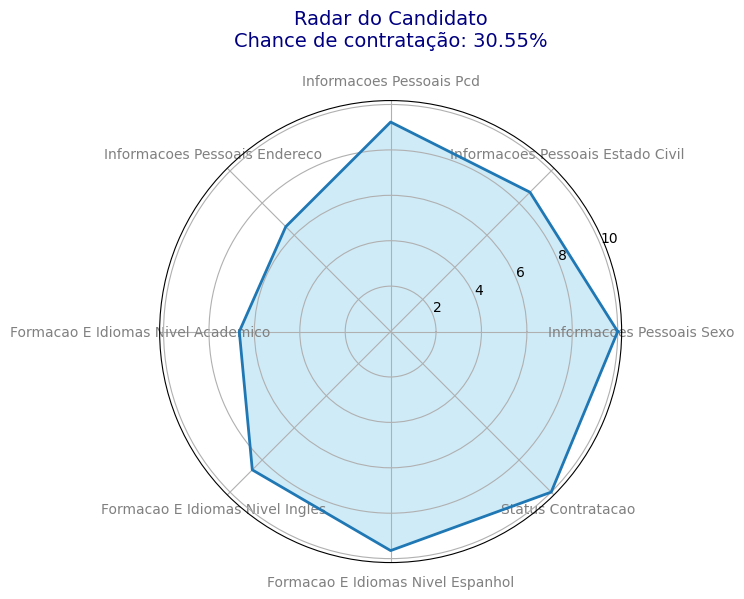

{'Informacoes Pessoais Sexo': np.float64(10.0),
 'Informacoes Pessoais Estado Civil': np.float64(8.678728946422877),
 'Informacoes Pessoais Pcd': np.float64(9.226970744468145),
 'Informacoes Pessoais Endereco': np.float64(6.531335655548025),
 'Formacao E Idiomas Nivel Academico': np.float64(6.6648012926912195),
 'Formacao E Idiomas Nivel Ingles': np.float64(8.614852123663896),
 'Formacao E Idiomas Nivel Espanhol': np.float64(9.646261757055901),
 'Status Contratacao': np.float64(10.0)}

In [42]:
radar_por_aderencia_modelo(linha=dados_historicos.iloc[128], modelo=modelo, valores_possiveis=valores_possiveis)

In [43]:
# Salvar o pipeline completo com pré-processamento + modelo

joblib.dump(modelo, 'modelo_ia_decision.joblib')

['modelo_ia_decision.joblib']

In [44]:
try:
    modelo = joblib.load("modelo_ia_decision.joblib")
    print("Modelo carregado com sucesso.")
except Exception as e:
    print("Erro ao carregar:", e)

Modelo carregado com sucesso.


In [45]:
def gerar_base_ficticia(n=20):

    candidatos = [
        {coluna: random.choice(opcoes) for coluna, opcoes in valores_possiveis.items()}
        for _ in range(n)
    ]

    df = pd.DataFrame(candidatos)

    # Garante que colunas indesejadas não existam
    colunas_a_excluir = ['status_contratacao', 'contratado']
    df = df.drop(columns=[c for c in colunas_a_excluir if c in df.columns], errors='ignore')

    df.to_csv("base_candidatos.csv", index=False)
    return df

In [46]:
# Gerar exemplo

gerar_base_ficticia(n=5)

,informacoes_pessoais_sexo,informacoes_pessoais_estado_civil,informacoes_pessoais_pcd,informacoes_pessoais_endereco,formacao_e_idiomas_nivel_academico,formacao_e_idiomas_nivel_ingles,formacao_e_idiomas_nivel_espanhol
0,Masculino,Casado,Sim,pará,Ensino Técnico Cursando,Avançado,Nenhum
1,Masculino,Solteiro,Sim,alagoas,Ensino Superior Incompleto,Avançado,Nenhum
2,Feminino,União Estável,Sim,acre,Mestrado Completo,Avançado,Nenhum
3,Feminino,Separado Judicialmente,Sim,rio grande do norte,Ensino Fundamental Cursando,Nenhum,Básico
4,Masculino,Solteiro,Sim,mato grosso,Mestrado Completo,Fluente,Básico


### 8. **Valor Gerado**
**Impactos práticos da solução:**
- Automação parcial da entrevista técnica, com insights sobre chances reais de contratação.
- Redução do tempo de triagem e priorização de candidatos com melhor perfil.
- Geração de base fictícia para simular novos candidatos, possibilitando a validação do modelo continuamente.
- Base para expansão do modelo usando NLP, dados semiestruturados e Deep Learning.